Forest fire notebook
https://github.com/projectmesa/mesa/blob/master/examples/forest_fire/Forest%20Fire%20Model.ipynb

Visualization
file:///Users/julianchan/Desktop/Materials-datascience/data_visualization/drawing_maps/README.html

a. Folium
https://python-visualization.github.io/folium/
https://pypi.org/project/folium/
b. Geo Pandas
http://geopandas.org/mapping.html#choropleth-maps

Data:
(Kaggle) https://www.kaggle.com/elikplim/predict-the-burned-area-of-forest-fires/data



1. Explain the model
2. Vary the parameters of the parameters- ([activation], duration of burning, [states] (on fire),[density], distribution of trees, wind, altitude, wind, random chance of catching fire)
3. Data visualization- Display the model against a map of the region/town and make an animation, heat map of the region - GEO PANDAS or FOLIUM
4. Satellite image of Californa of the forest fire

In [220]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [158]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"
        #print(self.condition)
            
        

In [235]:
class ForestFire(Model):
    import random
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        self.matrix = np.zeros((width, height))
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if self.random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    ##Edit below to change the location of the fire <--------------------------
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    ##Edits below ----------------------------------
                    if new_tree.condition == "On Fire":
                        self.matrix[x][y] = 1
                    if new_tree.condition == "Burned Out":
                        self.matrix[x][y] = 1
                    if new_tree.condition == "Fine":
                        self.matrix[x][y] = 0
                    self.schedule.add(new_tree)
        self.running = True
        #print(self.matrix)

    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
            if tree.condition == "Burned Out":
                model.matrix[tree.pos[0]][tree.pos[1]] = 1
            if tree.condition == "On Fire":
                model.matrix[tree.pos[0]][tree.pos[1]] = 1
        return count
    

In [314]:
def matrix_to_square(matrix,i,j,n,m):
    m_slice = matrix[math.floor(j*matrix.shape[0]/(n+1)): math.ceil((j+1)*matrix.shape[0]/(n+1))][math.floor(i*matrix.shape[1]/(m+1)): math.ceil((i+1)* matrix.shape[1]/(m+1))] 
    return m_slice


In [293]:
def burn_ratio(matrix):
    total = matrix.shape[0] * matrix.shape[1]
    count = matrix.sum()
    return count/total

## Run the model

In [294]:
fire = ForestFire(4, 20, 0.5)

In [295]:
fire.run_model()

In [139]:
results = fire.dc.get_model_vars_dataframe()

In [54]:
#fire.grid
#fire.schedule.agents
#fire.schedule

In [7]:
results.head(10)

,Fine,On Fire,Burned Out
0,1373,46,71
1,1318,31,141
2,1274,26,190
3,1230,25,235
4,1198,14,278
5,1166,17,307
6,1146,14,330
7,1110,23,357
8,1070,22,398
9,1026,22,442


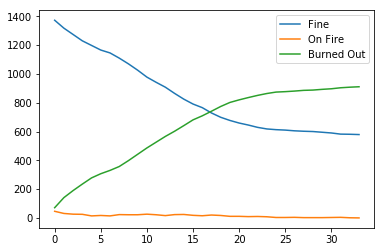

In [8]:
results.plot()

In [9]:
fixed_params = dict(height=50, # Height and width are constant
                 width=50)
# Vary density from 0.01 to 1, in 0.01 increments:
variable_params = dict(density=np.linspace(0,1,101)[1:])

In [10]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }

In [11]:
# Create the batch runner
param_run = BatchRunner(ForestFire, variable_parameters=variable_params, 
                        fixed_parameters=fixed_params, model_reporters=model_reporter)

In [12]:
param_run.run_all()

100it [00:07,  6.28it/s]


In [13]:
df = param_run.get_model_vars_dataframe()

In [14]:
df.head()

,density,Run,BurnedOut,height,width
0,0.01,0,0.000000,50,50
72,0.73,0,0.992762,50,50
71,0.72,0,0.986034,50,50
70,0.71,0,0.983662,50,50
69,0.70,0,0.967611,50,50


(0, 1)

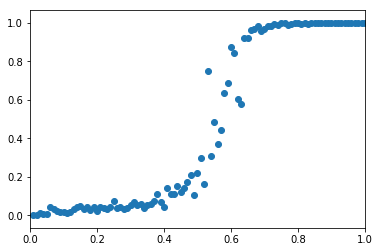

In [15]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

500it [00:36,  6.80it/s] 


(0, 1)

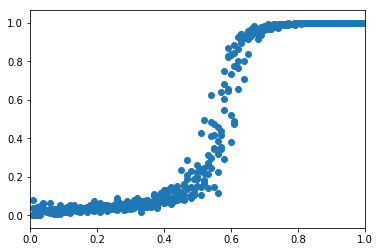

In [16]:
param_run = BatchRunner(ForestFire, variable_params, fixed_params, 
                        iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)